In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/GACHON/Desktop/AiStudy/data/UCI HAR Dataset-20240320T080931Z-001/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1> BiLSTM1 - BiGRU1 </h1>

In [10]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128, 256)         141312    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [11]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 8s 44ms/step - loss: 1.0954 - accuracy: 0.5418 - val_loss: 0.9118 - val_accuracy: 0.6591
Epoch 2/100
58/58 [==============================] - 2s 29ms/step - loss: 0.8345 - accuracy: 0.6563 - val_loss: 0.6730 - val_accuracy: 0.7416
Epoch 3/100
58/58 [==============================] - 2s 29ms/step - loss: 0.5755 - accuracy: 0.7716 - val_loss: 0.6296 - val_accuracy: 0.7466
Epoch 4/100
58/58 [==============================] - 2s 30ms/step - loss: 0.5175 - accuracy: 0.7821 - val_loss: 0.4375 - val_accuracy: 0.8223
Epoch 5/100
58/58 [==============================] - 2s 29ms/step - loss: 0.3436 - accuracy: 0.8614 - val_loss: 0.2597 - val_accuracy: 0.9202
Epoch 6/100
58/58 [==============================] - 2s 29ms/step - loss: 0.2195 - accuracy: 0.9192 - val_loss: 0.1821 - val_accuracy: 0.9229
Epoch 7/100
58/58 [==============================] - 2s 29ms/step - loss: 0.1658 - accuracy: 0.9344 - val_loss: 0.1534 - val_accuracy: 0.9329
Epoch 

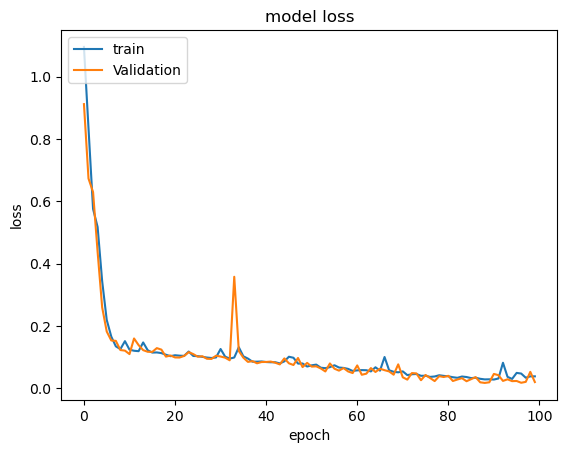

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

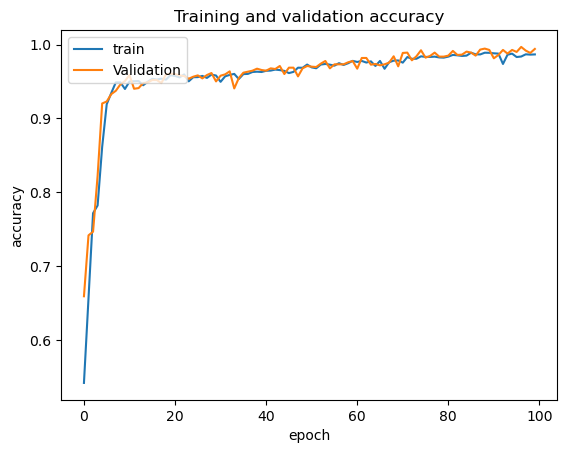

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 8ms/step
[[469   0  26   0   1   0]
 [  2 445  24   0   0   0]
 [  0   1 419   0   0   0]
 [  0  17   0 384  83   7]
 [  1   1   0  31 499   0]
 [  0   0   0   0   0 537]]
0.9341703427214116
0.9334155179062424
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.96      0.94      0.95       471
           2       0.89      1.00      0.94       420
           3       0.93      0.78      0.85       491
           4       0.86      0.94      0.90       532
           5       0.99      1.00      0.99       537

    accuracy                           0.93      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.94      0.93      0.93      2947



<Axes: >

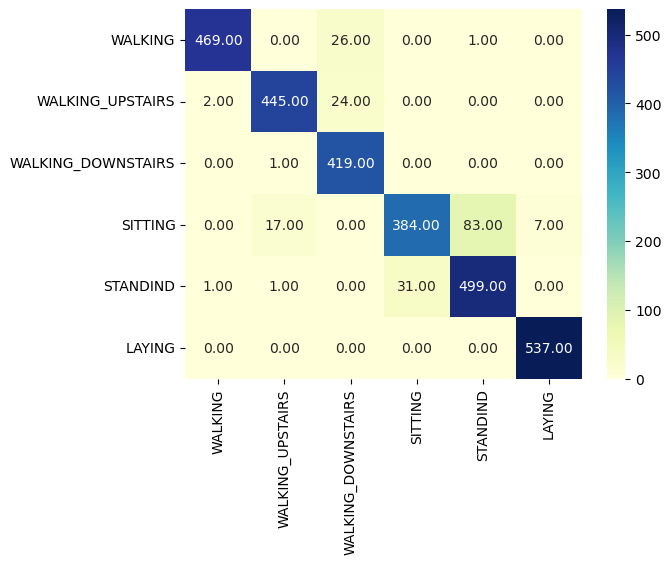

In [14]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - BiGRU1 </h1>

In [15]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 128, 256)         141312    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128, 256)         394240    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                      

In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 7s 62ms/step - loss: 1.0226 - accuracy: 0.5603 - val_loss: 0.6255 - val_accuracy: 0.7611
Epoch 2/100
58/58 [==============================] - 3s 46ms/step - loss: 0.5861 - accuracy: 0.7708 - val_loss: 0.4601 - val_accuracy: 0.8173
Epoch 3/100
58/58 [==============================] - 3s 46ms/step - loss: 0.4399 - accuracy: 0.8407 - val_loss: 0.2904 - val_accuracy: 0.8908
Epoch 4/100
58/58 [==============================] - 3s 46ms/step - loss: 0.2573 - accuracy: 0.9090 - val_loss: 0.2572 - val_accuracy: 0.8926
Epoch 5/100
58/58 [==============================] - 3s 46ms/step - loss: 0.2191 - accuracy: 0.9178 - val_loss: 0.1414 - val_accuracy: 0.9515
Epoch 6/100
58/58 [==============================] - 3s 46ms/step - loss: 0.1601 - accuracy: 0.9402 - val_loss: 0.1533 - val_accuracy: 0.9325
Epoch 7/100
58/58 [==============================] - 3s 46ms/step - loss: 0.1511 - accuracy: 0.9396 - val_loss: 0.1547 - val_accuracy: 0.9302
Epoch 

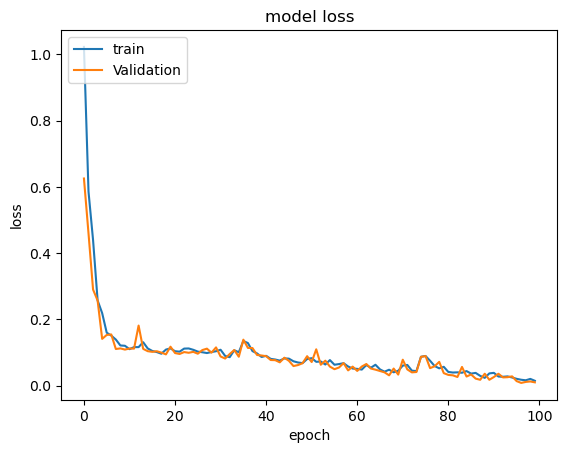

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

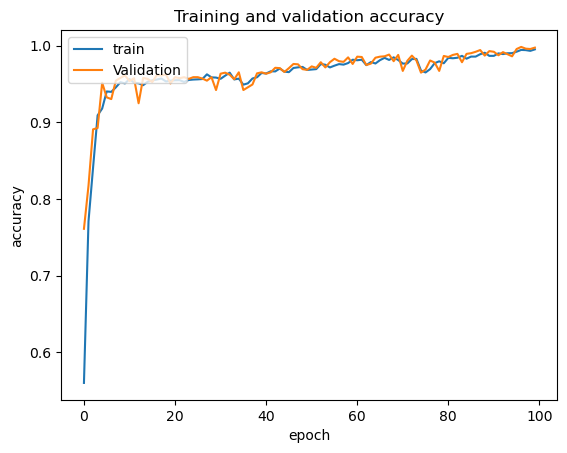

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 12ms/step
[[468   1  27   0   0   0]
 [  1 467   3   0   0   0]
 [  2   0 418   0   0   0]
 [  0   5   0 414  51  21]
 [  1   3   0  19 509   0]
 [  0   0   0   0   0 537]]
0.9545300305395318
0.953950069398684
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       496
           1       0.98      0.99      0.99       471
           2       0.93      1.00      0.96       420
           3       0.96      0.84      0.90       491
           4       0.91      0.96      0.93       532
           5       0.96      1.00      0.98       537

    accuracy                           0.95      2947
   macro avg       0.96      0.96      0.95      2947
weighted avg       0.96      0.95      0.95      2947



<Axes: >

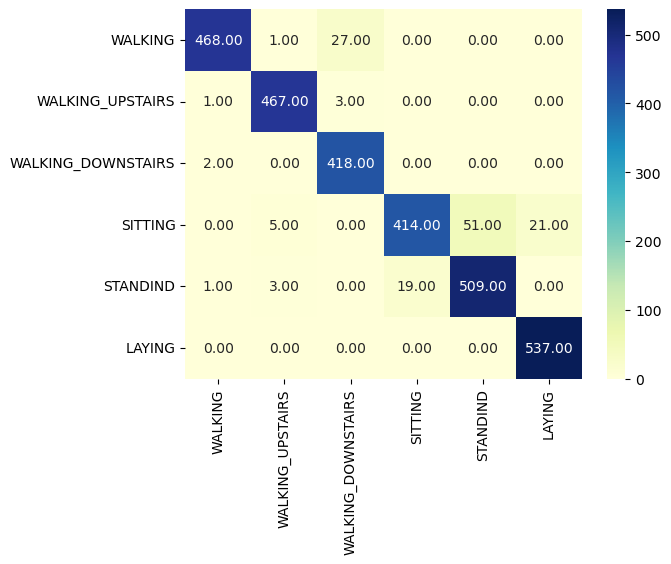

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM1 - BiGRU2 </h1>

In [20]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 128, 256)         141312    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 128, 256)         296448    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                      

In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 7s 56ms/step - loss: 1.0774 - accuracy: 0.5431 - val_loss: 0.7155 - val_accuracy: 0.7312
Epoch 2/100
58/58 [==============================] - 2s 43ms/step - loss: 0.5896 - accuracy: 0.7655 - val_loss: 0.5555 - val_accuracy: 0.8232
Epoch 3/100
58/58 [==============================] - 2s 42ms/step - loss: 0.3957 - accuracy: 0.8570 - val_loss: 0.2502 - val_accuracy: 0.9048
Epoch 4/100
58/58 [==============================] - 2s 42ms/step - loss: 0.2142 - accuracy: 0.9200 - val_loss: 0.2001 - val_accuracy: 0.9193
Epoch 5/100
58/58 [==============================] - 2s 42ms/step - loss: 0.1705 - accuracy: 0.9344 - val_loss: 0.1308 - val_accuracy: 0.9524
Epoch 6/100
58/58 [==============================] - 2s 42ms/step - loss: 0.1400 - accuracy: 0.9464 - val_loss: 0.1161 - val_accuracy: 0.9551
Epoch 7/100
58/58 [==============================] - 2s 42ms/step - loss: 0.1287 - accuracy: 0.9482 - val_loss: 0.1351 - val_accuracy: 0.9374
Epoch 

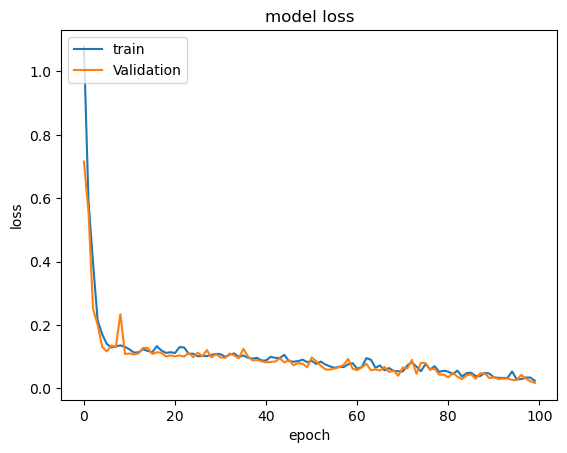

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

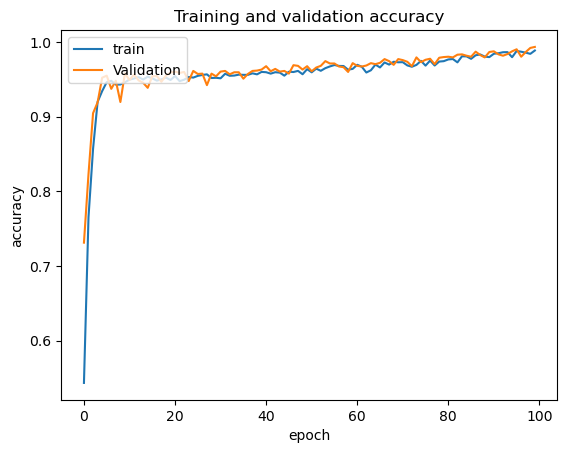

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 12ms/step
[[455   1  40   0   0   0]
 [  5 441  25   0   0   0]
 [  0   1 419   0   0   0]
 [  0   3   0 382  84  22]
 [  1   0   0  57 474   0]
 [  0   0   0   0   0 537]]
0.9189005768578216
0.9183146413302296
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       496
           1       0.99      0.94      0.96       471
           2       0.87      1.00      0.93       420
           3       0.87      0.78      0.82       491
           4       0.85      0.89      0.87       532
           5       0.96      1.00      0.98       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

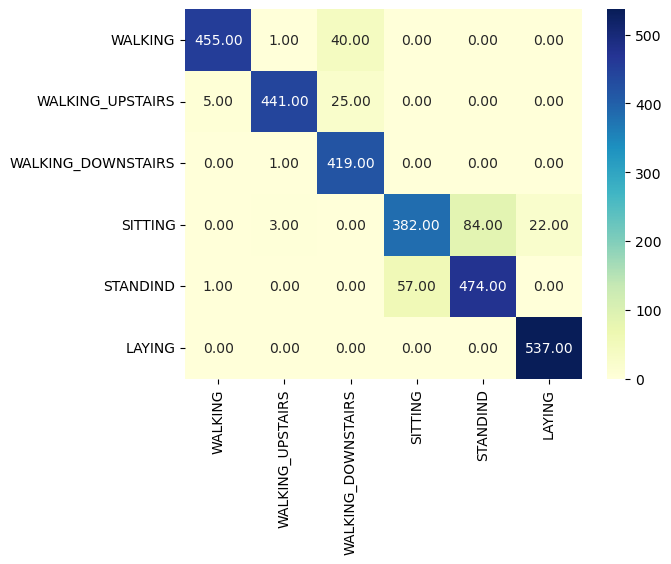

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - BiGRU2 </h1>

In [25]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 128, 256)         141312    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 128, 256)         394240    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 128, 256)         296448    
 onal)                                                           
                                                      

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 9s 79ms/step - loss: 1.0473 - accuracy: 0.5558 - val_loss: 0.6634 - val_accuracy: 0.7167
Epoch 2/100
58/58 [==============================] - 3s 60ms/step - loss: 0.4826 - accuracy: 0.8146 - val_loss: 0.3381 - val_accuracy: 0.8840
Epoch 3/100
58/58 [==============================] - 3s 60ms/step - loss: 0.3193 - accuracy: 0.8904 - val_loss: 0.2063 - val_accuracy: 0.9297
Epoch 4/100
58/58 [==============================] - 3s 60ms/step - loss: 0.1857 - accuracy: 0.9290 - val_loss: 0.2307 - val_accuracy: 0.8976
Epoch 5/100
58/58 [==============================] - 3s 60ms/step - loss: 0.2133 - accuracy: 0.9238 - val_loss: 0.1335 - val_accuracy: 0.9497
Epoch 6/100
58/58 [==============================] - 3s 59ms/step - loss: 0.1363 - accuracy: 0.9444 - val_loss: 0.1143 - val_accuracy: 0.9474
Epoch 7/100
58/58 [==============================] - 3s 59ms/step - loss: 0.1179 - accuracy: 0.9513 - val_loss: 0.1123 - val_accuracy: 0.9583
Epoch 

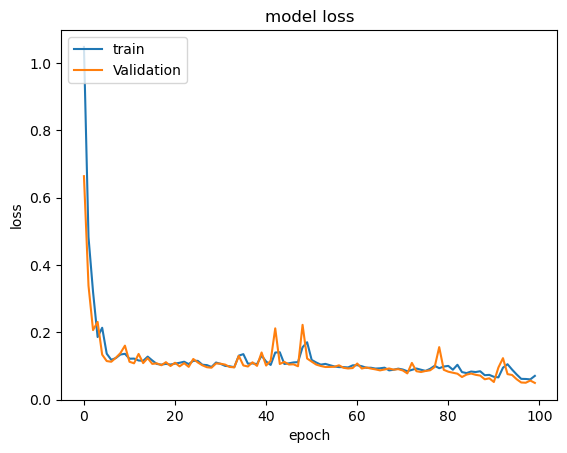

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

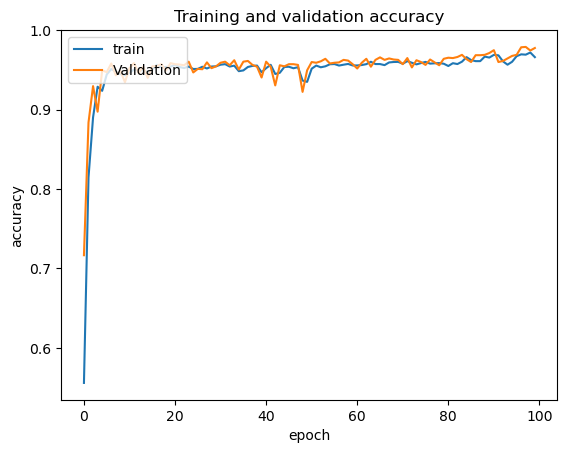

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 15ms/step
[[465   3  28   0   0   0]
 [  4 450  15   2   0   0]
 [  0   0 420   0   0   0]
 [  0  20   2 418  51   0]
 [  1   0   0 112 419   0]
 [  0  27   0   0   0 510]]
0.9100780454699695
0.9100933711949509
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       496
           1       0.90      0.96      0.93       471
           2       0.90      1.00      0.95       420
           3       0.79      0.85      0.82       491
           4       0.89      0.79      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

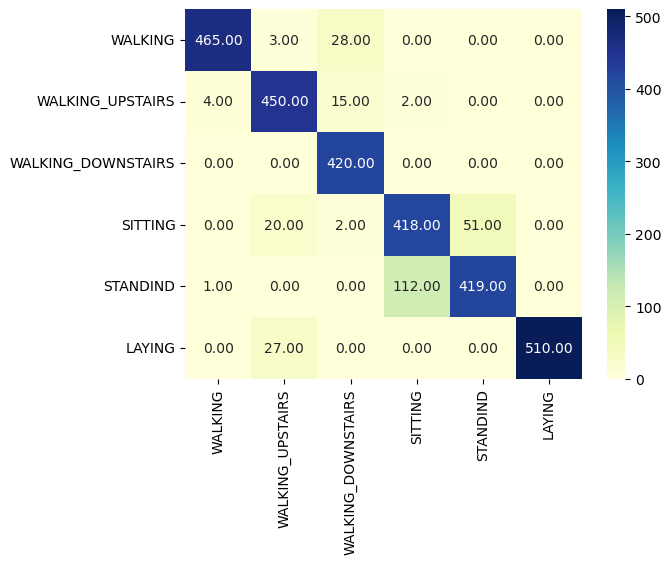

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - BiGRU2 (Crossed)</h1>

In [30]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 128, 256)         141312    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 128, 256)         296448    
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 128, 256)         394240    
 onal)                                                           
                                                      

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 10s 82ms/step - loss: 1.0392 - accuracy: 0.5490 - val_loss: 0.6663 - val_accuracy: 0.7257
Epoch 2/100
58/58 [==============================] - 3s 60ms/step - loss: 0.5694 - accuracy: 0.7612 - val_loss: 0.4116 - val_accuracy: 0.8450
Epoch 3/100
58/58 [==============================] - 3s 60ms/step - loss: 0.3806 - accuracy: 0.8602 - val_loss: 0.2837 - val_accuracy: 0.8976
Epoch 4/100
58/58 [==============================] - 3s 60ms/step - loss: 0.2600 - accuracy: 0.9064 - val_loss: 0.1686 - val_accuracy: 0.9411
Epoch 5/100
58/58 [==============================] - 3s 60ms/step - loss: 0.1742 - accuracy: 0.9324 - val_loss: 0.1320 - val_accuracy: 0.9519
Epoch 6/100
58/58 [==============================] - 4s 61ms/step - loss: 0.1340 - accuracy: 0.9456 - val_loss: 0.1186 - val_accuracy: 0.9533
Epoch 7/100
58/58 [==============================] - 3s 60ms/step - loss: 0.1353 - accuracy: 0.9463 - val_loss: 0.1509 - val_accuracy: 0.9397
Epoch

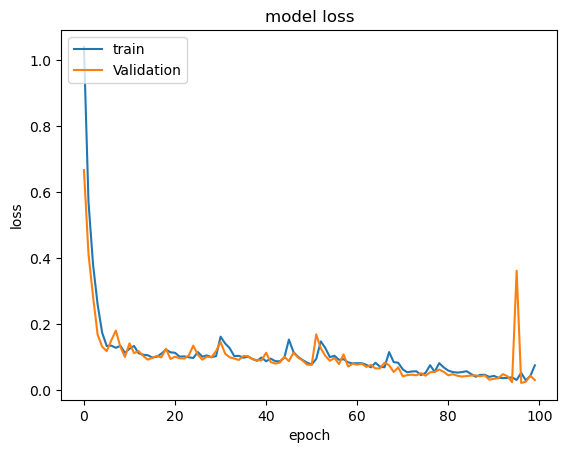

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

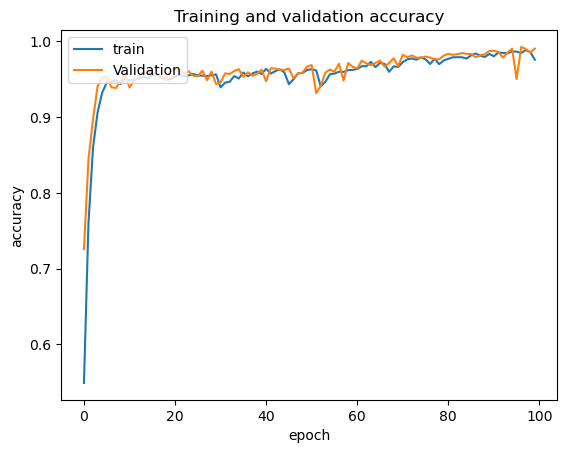

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 17ms/step
[[470   0  26   0   0   0]
 [ 13 434  24   0   0   0]
 [  0   1 419   0   0   0]
 [  0   2   0 421  63   5]
 [  0   1   0  38 493   0]
 [  0   0   0   0   0 537]]
0.9412962334577536
0.9412012172139056
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       496
           1       0.99      0.92      0.95       471
           2       0.89      1.00      0.94       420
           3       0.92      0.86      0.89       491
           4       0.89      0.93      0.91       532
           5       0.99      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

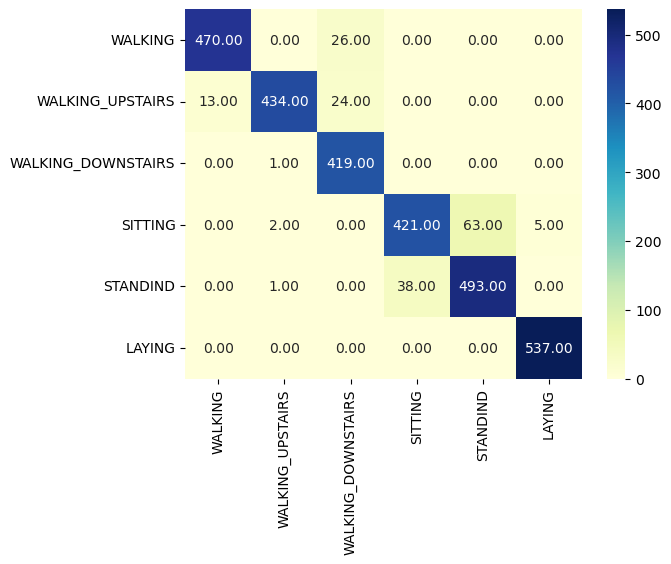

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM3 - BiGRU3 </h1>

In [35]:
from tensorflow.keras.layers import LSTM, GRU
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 128, 256)         141312    
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_17 (Bidirecti  (None, 128, 256)         394240    
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 128, 256)         394240    
 onal)                                                           
                                                      

In [36]:
# validation_split = 0.1
batch_size = 128

train_epochs = 100
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/100
58/58 [==============================] - 14s 120ms/step - loss: 1.0532 - accuracy: 0.5450 - val_loss: 0.7286 - val_accuracy: 0.6632
Epoch 2/100
58/58 [==============================] - 5s 91ms/step - loss: 0.6168 - accuracy: 0.7390 - val_loss: 0.5754 - val_accuracy: 0.7294
Epoch 3/100
58/58 [==============================] - 5s 91ms/step - loss: 0.5350 - accuracy: 0.7915 - val_loss: 0.3002 - val_accuracy: 0.8908
Epoch 4/100
58/58 [==============================] - 5s 91ms/step - loss: 0.2865 - accuracy: 0.8943 - val_loss: 0.2415 - val_accuracy: 0.8962
Epoch 5/100
58/58 [==============================] - 5s 93ms/step - loss: 0.1971 - accuracy: 0.9266 - val_loss: 0.2035 - val_accuracy: 0.9284
Epoch 6/100
58/58 [==============================] - 5s 93ms/step - loss: 0.1668 - accuracy: 0.9372 - val_loss: 0.1260 - val_accuracy: 0.9442
Epoch 7/100
58/58 [==============================] - 5s 91ms/step - loss: 0.1610 - accuracy: 0.9388 - val_loss: 0.1262 - val_accuracy: 0.9470
Epoc

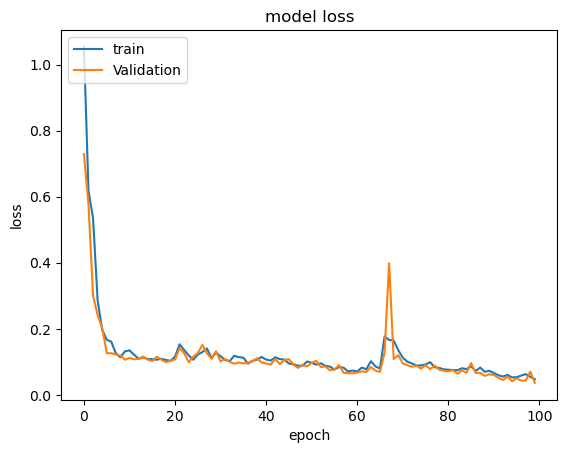

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

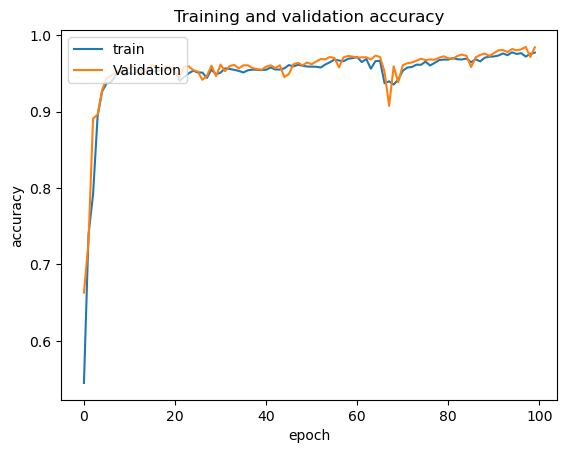

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 4s 26ms/step
[[461   8  21   6   0   0]
 [  7 446  16   1   1   0]
 [  9   8 401   2   0   0]
 [  0   7   0 405  79   0]
 [  0   1   0  40 491   0]
 [  0  17   0   0   0 520]]
0.9243298269426535
0.9243299007181668
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       496
           1       0.92      0.95      0.93       471
           2       0.92      0.95      0.93       420
           3       0.89      0.82      0.86       491
           4       0.86      0.92      0.89       532
           5       1.00      0.97      0.98       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.93      0.92      0.92      2947



<Axes: >

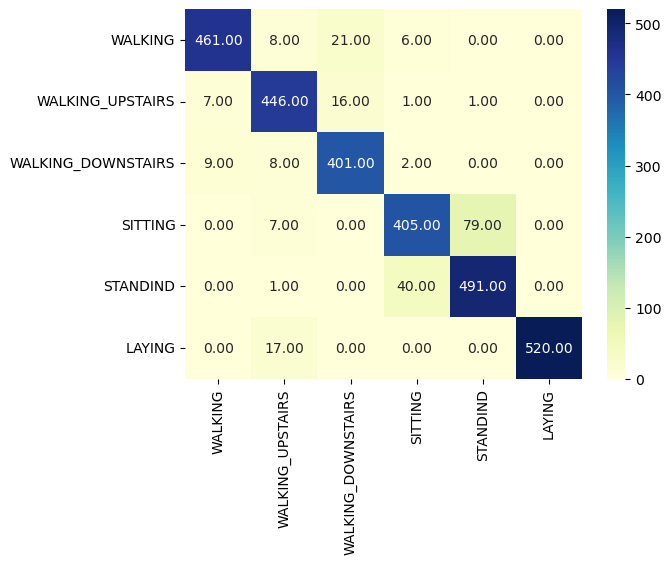

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')